#### Import library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

#### Load dataset

In [2]:
df = pd.read_csv("D:\Projects\Sales_EDA_Dashboard\Data\Processed\Sales_Data_Clean.csv")
df.head()

,Unnamed: 0,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Month,Sales,City,Hour,Year,Day,Weekday
0,0,295665,Macbook Pro Laptop,1,1700.00,2019-12-30 00:01:00,"136 Church St, New York City, NY 10001",12,1700.00,New York City,0,2019,30,Monday
1,1,295666,LG Washing Machine,1,600.00,2019-12-29 07:03:00,"562 2nd St, New York City, NY 10001",12,600.00,New York City,7,2019,29,Sunday
2,2,295667,USB-C Charging Cable,1,11.95,2019-12-12 18:21:00,"277 Main St, New York City, NY 10001",12,11.95,New York City,18,2019,12,Thursday
3,3,295668,27in FHD Monitor,1,149.99,2019-12-22 15:13:00,"410 6th St, San Francisco, CA 94016",12,149.99,San Francisco,15,2019,22,Sunday
4,4,295669,USB-C Charging Cable,1,11.95,2019-12-18 12:38:00,"43 Hill St, Atlanta, GA 30301",12,11.95,Atlanta,12,2019,18,Wednesday


#### Overview of Dataset: columns, dtypes, non-null counts

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185950 entries, 0 to 185949
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        185950 non-null  int64  
 1   Order ID          185950 non-null  int64  
 2   Product           185950 non-null  object 
 3   Quantity Ordered  185950 non-null  int64  
 4   Price Each        185950 non-null  float64
 5   Order Date        185950 non-null  object 
 6   Purchase Address  185950 non-null  object 
 7   Month             185950 non-null  int64  
 8   Sales             185950 non-null  float64
 9   City              185950 non-null  object 
 10  Hour              185950 non-null  int64  
 11  Year              185950 non-null  int64  
 12  Day               185950 non-null  int64  
 13  Weekday           185950 non-null  object 
dtypes: float64(2), int64(7), object(5)
memory usage: 19.9+ MB


#### Summary stats for numerical columns

In [4]:
df.describe()

,Unnamed: 0,Order ID,Quantity Ordered,Price Each,Month,Sales,Hour,Year,Day
count,185950.000000,185950.000000,185950.000000,185950.000000,185950.000000,185950.000000,185950.000000,185950.000000,185950.000000
mean,8340.388475,230417.569379,1.124383,184.399735,7.059140,185.490917,14.413305,2019.000183,15.759532
std,5450.554093,51512.737110,0.442793,332.731330,3.502996,332.919771,5.423416,0.013521,8.782176
min,0.000000,141234.000000,1.000000,2.990000,1.000000,2.990000,0.000000,2019.000000,1.000000
25%,3894.000000,185831.250000,1.000000,11.950000,4.000000,11.950000,11.000000,2019.000000,8.000000
50%,7786.000000,230367.500000,1.000000,14.950000,7.000000,14.950000,15.000000,2019.000000,16.000000
75%,11872.000000,275035.750000,1.000000,150.000000,10.000000,150.000000,19.000000,2019.000000,23.000000
max,25116.000000,319670.000000,9.000000,1700.000000,12.000000,3400.000000,23.000000,2020.000000,31.000000


#### Convert the type of data

In [5]:
df['Order Date'] = pd.to_datetime(df['Order Date'])

# Create a new dataframe
daily_sales = df.groupby(df['Order Date'].dt.date)['Sales'].sum().reset_index()

# Rename the column
daily_sales.rename(columns={'Order Date': 'date', 'Sales': 'sales'}, inplace=True)

# Set index as the date to make time series
daily_sales['date'] = pd.to_datetime(daily_sales['date'])
daily_sales = daily_sales.set_index('date')

daily_sales.head()

,sales
date,
2019-01-01,65681.94
2019-01-02,70813.20
2019-01-03,47046.20
2019-01-04,62012.21
2019-01-05,46524.63


#### Show shape of dataset (rows, columns)

In [6]:
daily_sales.shape

(366, 1)

#### Plotting time series to observe trends, seasonality, outliers

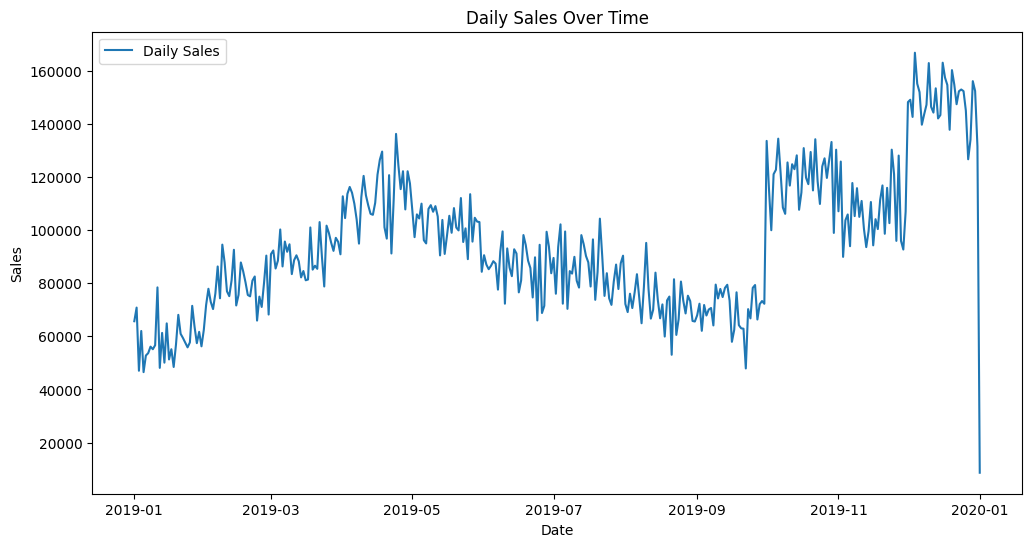

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(daily_sales.index, daily_sales["sales"], label="Daily Sales")
plt.title("Daily Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

It seems that the Daily Sales Series has some outliers, especially at the end of 2019 when volatility spiked. Since SARIMA is quite sensitive to outliers, these points may cause bias in reporting. Therefore, it is necessary to consider pre-processing the data before training the model.

#### Use IQR to fine outliers

In [8]:
# --- Find outlier using IQR ---
Q1 = daily_sales['sales'].quantile(0.25)
Q3 = daily_sales['sales'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Create a mask for "valid" data
mask = (daily_sales['sales'] >= lower_bound) & (daily_sales['sales'] <= upper_bound)

# --- View outlier ---
outliers = daily_sales[~mask]
print("Outliers:\n", outliers)

Outliers:
                 sales
date                 
2019-12-04  166727.69
2019-12-10  162832.74
2019-12-16  162970.61
2020-01-01    8670.29


In [9]:
# --- Clean data ---
daily_sales = daily_sales[mask].copy()

# Make sure the index is a DatetimeIndex and has a daily frequency
daily_sales.index = pd.to_datetime(daily_sales.index)

print("\nAfter remove outlier:")
print(daily_sales.head())


After remove outlier:
               sales
date                
2019-01-01  65681.94
2019-01-02  70813.20
2019-01-03  47046.20
2019-01-04  62012.21
2019-01-05  46524.63


### Modeling

#### Run auto_arima to automatically find the best ARIMA/SARIMA model for daily sales data

In [10]:
stepwise_model = auto_arima(
    daily_sales['sales'], 
    start_p=1, start_q=1,
    max_p=5, max_q=5, m=7, 
    start_P=0, seasonal=True, 
    d=None, D=1, trace=True,
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=True
)

print(stepwise_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=7720.694, Time=0.55 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=7856.893, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=7777.881, Time=0.28 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=7794.512, Time=0.22 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=7859.204, Time=0.05 sec
 ARIMA(1,0,1)(0,1,0)[7] intercept   : AIC=7815.339, Time=0.26 sec
 ARIMA(1,0,1)(1,1,1)[7] intercept   : AIC=7721.385, Time=0.58 sec
 ARIMA(1,0,1)(0,1,2)[7] intercept   : AIC=7722.676, Time=0.88 sec
 ARIMA(1,0,1)(1,1,0)[7] intercept   : AIC=7746.641, Time=0.39 sec
 ARIMA(1,0,1)(1,1,2)[7] intercept   : AIC=inf, Time=3.77 sec
 ARIMA(1,0,0)(0,1,1)[7] intercept   : AIC=7754.745, Time=0.35 sec
 ARIMA(2,0,1)(0,1,1)[7] intercept   : AIC=7715.333, Time=0.73 sec
 ARIMA(2,0,1)(0,1,0)[7] intercept   : AIC=7816.764, Time=0.42 sec
 ARIMA(2,0,1)(1,1,1)[7] intercept   : AIC=7716.722, Time=0.81 sec
 ARIMA(2,0,1)(0,1,2)[7] intercept   : 

The log result shows that auto_arima has tried many combinations (p,d,q)(P,D,Q)[m]
→ This is how to find the best set of parameters for the SARIMA model.

In log, the model with the smallest AIC is ARIMA(5,0,0)(0,1,1)[7], with AIC ≈ 7698.599
That means the Seasonal ARIMA model has:

- p=5, d=0, q=0 (non-seasonal ARIMA)

- P=0, D=1, Q=1 (seasonal ARIMA)

- m=7 (weekly seasonality cycle)

=> This is the optimal model chosen by auto_arima to forecast daily sales.

The meaning of AIC in choosing ARIMA model
- **AIC (Akaike Information Criterion)** is used to compare models.
- Formula: `AIC = 2k - 2ln(L)`
- `k`: number of model parameters
- `L`: suitability (likelihood)
- AIC balances between:
- Data fit (high likelihood)
- Complexity (fewer parameters is better)
- **The model with the smallest AIC → is selected as the optimal model**.
- In the above results, **ARIMA(5,0,0)(0,1,1)[7]** has AIC ≈ 7698,6 → is the best model.

#### Train/test split over time

In [11]:
# Assuming daily_sales is a prepared series: index=DatetimeIndex (date), column 'sales'
y = daily_sales['sales'].astype(float)

# 80% train – 20% test
split_idx = int(len(y)*0.8)
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

#### Fit model on train

In [12]:
sarima_model_weekly = sm.tsa.statespace.SARIMAX(
    y_train, 
    order=(5,0,0),              
    seasonal_order=(0,1,1,7),  
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

#### Prediction on Test set

In [13]:
y_pred_weekly = sarima_model_weekly.predict(
    start=len(y_train),
    end=len(y_train) + len(y_test) - 1,
    dynamic=False
)

#### Evaluation

In [14]:
# Metrics 
mae  = mean_absolute_error(y_test, y_pred_weekly)
rmse = sqrt(mean_squared_error(y_test, y_pred_weekly))
mape = (np.abs((y_test - y_pred_weekly) / y_test)
        .replace([np.inf, -np.inf], np.nan).dropna()).mean()*100

print(f"MAE : {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"MAPE: {mape:,.2f}%")

MAE : 18,570.96
RMSE: 21,872.42
MAPE: 14.24%


#### Plot Actual vs Forecast (Test)

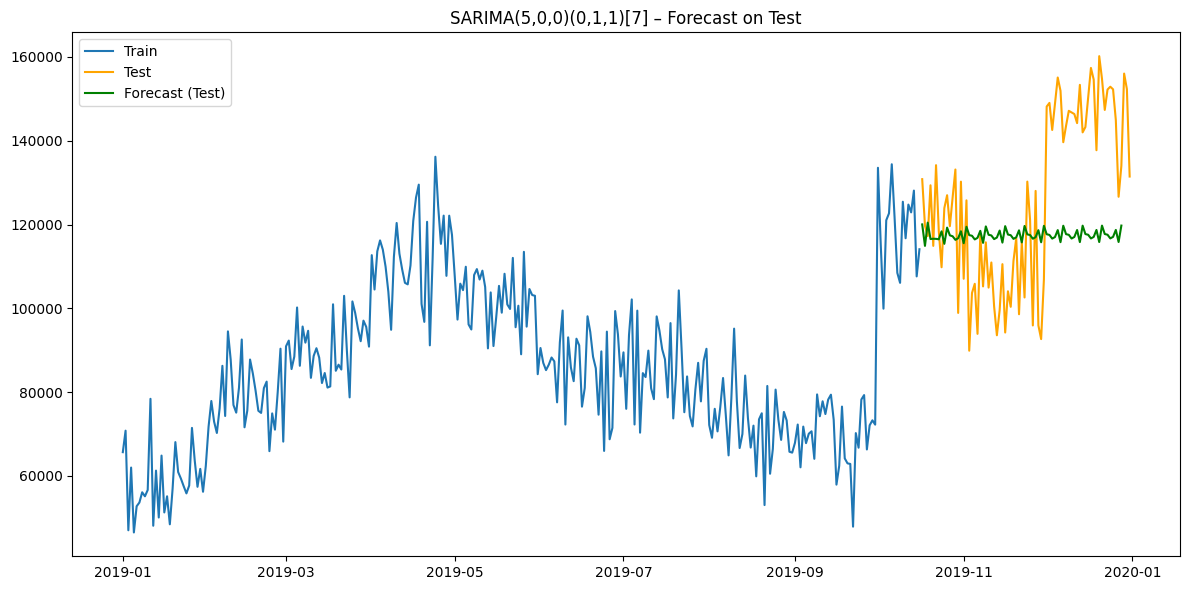

In [15]:
plt.figure(figsize=(12,6))
plt.plot(y_train.index, y_train, label="Train")
plt.plot(y_test.index,  y_test,  label="Test", color='orange')
plt.plot(y_pred_weekly.index,    y_pred_weekly,    label="Forecast (Test)", color='green')
plt.title("SARIMA(5,0,0)(0,1,1)[7] – Forecast on Test")
plt.legend(); plt.tight_layout(); plt.show()

#### Check residual (forecast error)

Residual mean: 6964.51


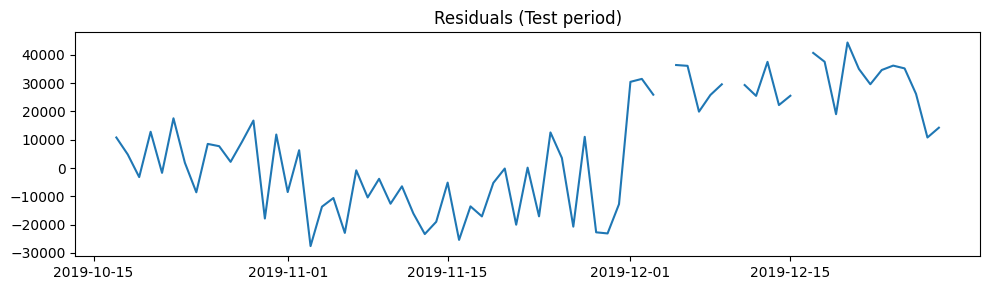

In [16]:
resid = y_test - y_pred_weekly
print("Residual mean:", resid.mean().round(2))

plt.figure(figsize=(10,3))
plt.plot(resid.index, resid.values)
plt.title("Residuals (Test period)")
plt.tight_layout(); plt.show()

#### Refit all data $ Forecast future

In [17]:
# Retrain on the entire dataset
weekly_sarima = sm.tsa.statespace.SARIMAX(
    daily_sales['sales'],    
    order=(5,0,0),           
    seasonal_order=(0,1,1,7),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

#### Draw future forecast

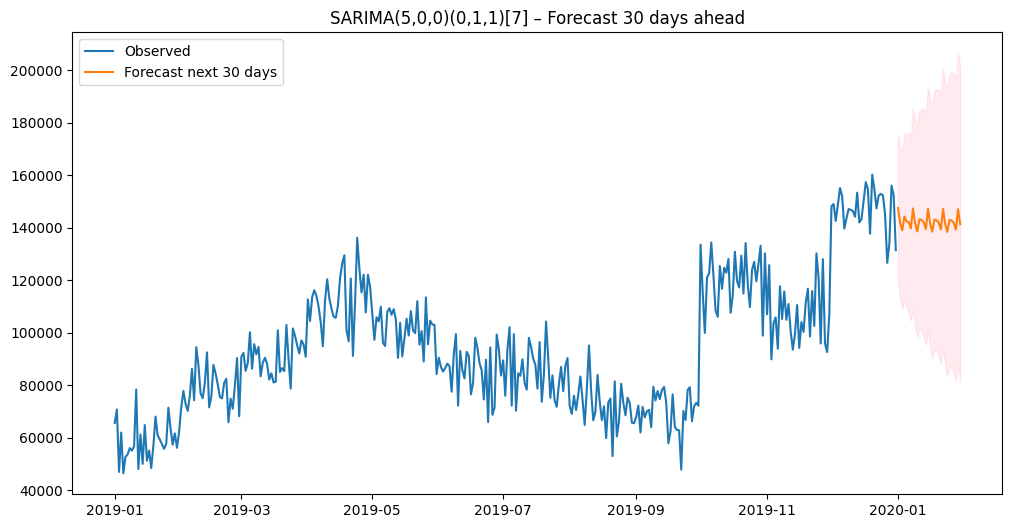

In [18]:
# Forecast for the next 30 days
n_steps = 30  # number of future days to forecast
forecast_future = weekly_sarima.get_forecast(steps=n_steps)

# Get mean and confidence interval
forecast_mean = forecast_future.predicted_mean
forecast_ci = forecast_future.conf_int()

# Create index for forecast
forecast_index = pd.date_range(start=daily_sales.index[-1] + pd.Timedelta(days=1),
                               periods=n_steps, freq="D")
forecast_mean.index = forecast_index
forecast_ci.index = forecast_index

# Draw chart
plt.figure(figsize=(12,6))
plt.plot(daily_sales['sales'], label="Observed")
plt.plot(forecast_mean, label=f"Forecast next {n_steps} days")
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color="pink", alpha=0.3)
plt.title(f"SARIMA(5,0,0)(0,1,1)[7] – Forecast {n_steps} days ahead")
plt.legend()
plt.show()


#### First, we used m=7 to capture weekly seasonality.
#### Now, re-run auto_arima with m=30 to search for the best-fit SARIMA model with monthly seasonality.

In [19]:
stepwise_model = auto_arima(
    daily_sales['sales'], 
    start_p=1, start_q=1,
    max_p=5, max_q=5, m=30,  
    start_P=0, seasonal=True, 
    d=None, D=1, trace=True,
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=True
)

print(stepwise_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[30]             : AIC=inf, Time=4.17 sec
 ARIMA(0,1,0)(0,1,0)[30]             : AIC=7435.377, Time=0.21 sec
 ARIMA(1,1,0)(1,1,0)[30]             : AIC=7287.228, Time=2.87 sec
 ARIMA(0,1,1)(0,1,1)[30]             : AIC=inf, Time=2.99 sec
 ARIMA(1,1,0)(0,1,0)[30]             : AIC=7358.187, Time=0.32 sec
 ARIMA(1,1,0)(2,1,0)[30]             : AIC=7260.209, Time=8.47 sec
 ARIMA(1,1,0)(2,1,1)[30]             : AIC=inf, Time=19.27 sec
 ARIMA(1,1,0)(1,1,1)[30]             : AIC=inf, Time=4.93 sec
 ARIMA(0,1,0)(2,1,0)[30]             : AIC=7300.853, Time=6.45 sec
 ARIMA(2,1,0)(2,1,0)[30]             : AIC=7220.498, Time=12.22 sec
 ARIMA(2,1,0)(1,1,0)[30]             : AIC=7251.109, Time=3.36 sec
 ARIMA(2,1,0)(2,1,1)[30]             : AIC=7211.420, Time=24.39 sec
 ARIMA(2,1,0)(1,1,1)[30]             : AIC=inf, Time=6.11 sec
 ARIMA(2,1,0)(2,1,2)[30]             : AIC=7212.681, Time=42.57 sec
 ARIMA(2,1,0)(1,1,2)[30]             : A

The log result shows that auto_arima has tried many combinations (p,d,q)(P,D,Q)[m]
→ This is how to find the best set of parameters for the SARIMA model.

In log, the model with the smallest AIC is ARIMA(4,1,0)(2,1,1)[30], with AIC ≈ 7207.936
That means the Seasonal ARIMA model has:

- p=4, d=1, q=0 (non-seasonal ARIMA)

- P=2, D=1, Q=1 (seasonal ARIMA)

- m=30 (weekly seasonality cycle)

=> This is the optimal model chosen by auto_arima to forecast daily sales.

The meaning of AIC in choosing ARIMA model
- **AIC (Akaike Information Criterion)** is used to compare models.
- Formula: `AIC = 2k - 2ln(L)`
- `k`: number of model parameters
- `L`: suitability (likelihood)
- AIC balances between:
- Data fit (high likelihood)
- Complexity (fewer parameters is better)
- **The model with the smallest AIC → is selected as the optimal model**.
- In the above results, **ARIMA(4,1,0)(2,1,1)[30]** has AIC ≈ 7207.9 → is the best model.

#### auto_arima selected SARIMA(4,1,0)(2,1,1)[30] as the best model,
#### Fit SARIMA model with (4,1,0)(2,1,1)[30] (monthly seasonality)

In [20]:
sarima_model_m30 = sm.tsa.statespace.SARIMAX(
    y_train, 
    order=(4,1,0),              
    seasonal_order=(2,1,1,30),  
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

#### Prediction on the Test set

In [21]:
forecast_m30 = sarima_model_m30.predict(start=len(y_train), 
                                        end=len(y_train)+len(y_test)-1, 
                                        dynamic=False)

#### Evalation the model

In [22]:
mae = mean_absolute_error(y_test, forecast_m30)
rmse = np.sqrt(mean_squared_error(y_test, forecast_m30))
mape = np.mean(np.abs((y_test - forecast_m30) / y_test)) * 100

print("MAE :", round(mae, 2))
print("RMSE:", round(rmse, 2))
print("MAPE:", round(mape, 2), "%")

MAE : 16521.6
RMSE: 19369.16
MAPE: 14.0 %


#### Plot Actual vs Forecast (Test)

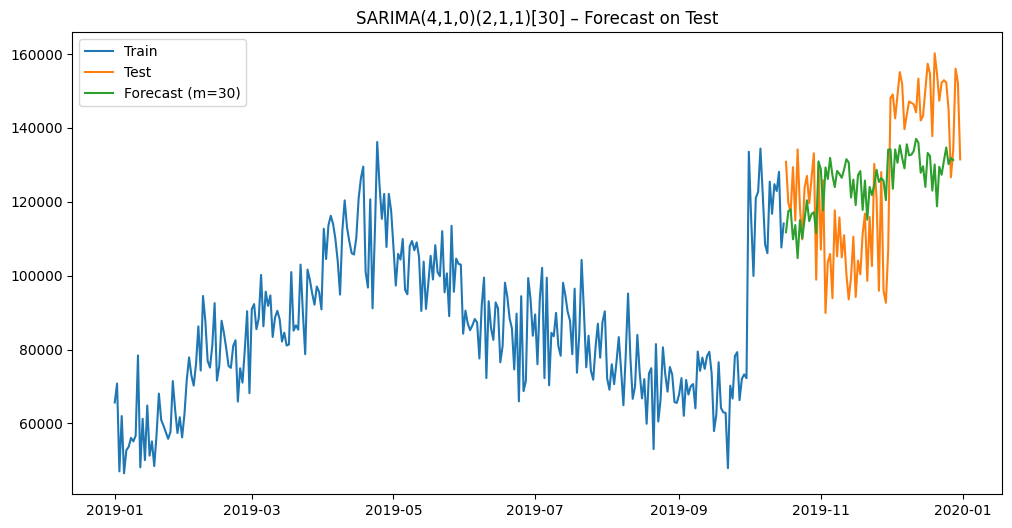

In [23]:
plt.figure(figsize=(12,6))
plt.plot(y_train, label="Train")
plt.plot(y_test, label="Test")
plt.plot(forecast_m30, label="Forecast (m=30)")
plt.title("SARIMA(4,1,0)(2,1,1)[30] – Forecast on Test")
plt.legend()
plt.show()

#### Check residual (forecast error)

Residual mean: 6964.51


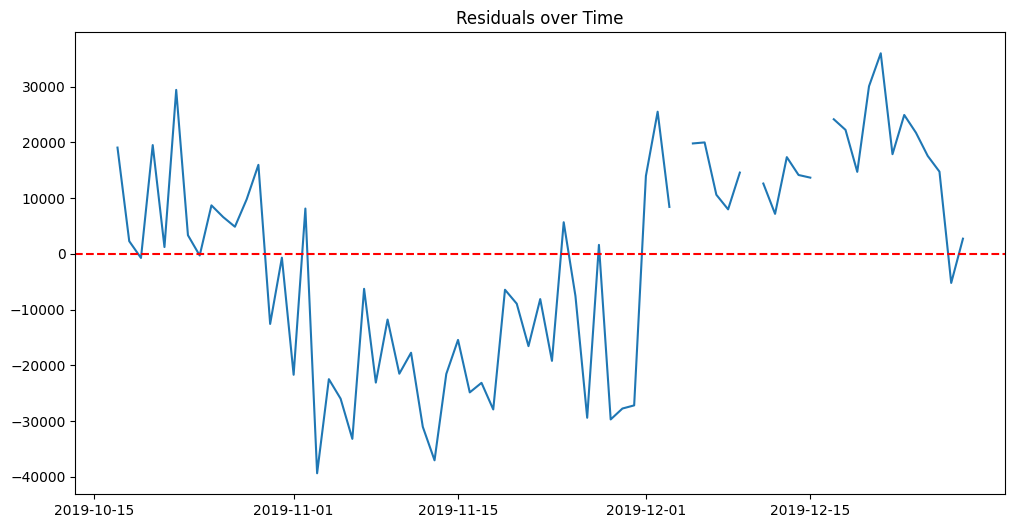

In [24]:
# Residuals (difference between actual and forecast)
residuals = y_test - forecast_m30
print("Residual mean:", resid.mean().round(2))

# Plot residuals over time
plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.axhline(0, linestyle="--", color="red")
plt.title("Residuals over Time")
plt.show()

#### Refit all data & Forecast future

In [25]:
# Retrain on the entire dataset
monthly_sarima = sm.tsa.statespace.SARIMAX(
    daily_sales['sales'],    
    order=(4,1,0),           
    seasonal_order=(2,1,1,30),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

#### Draw future forecast

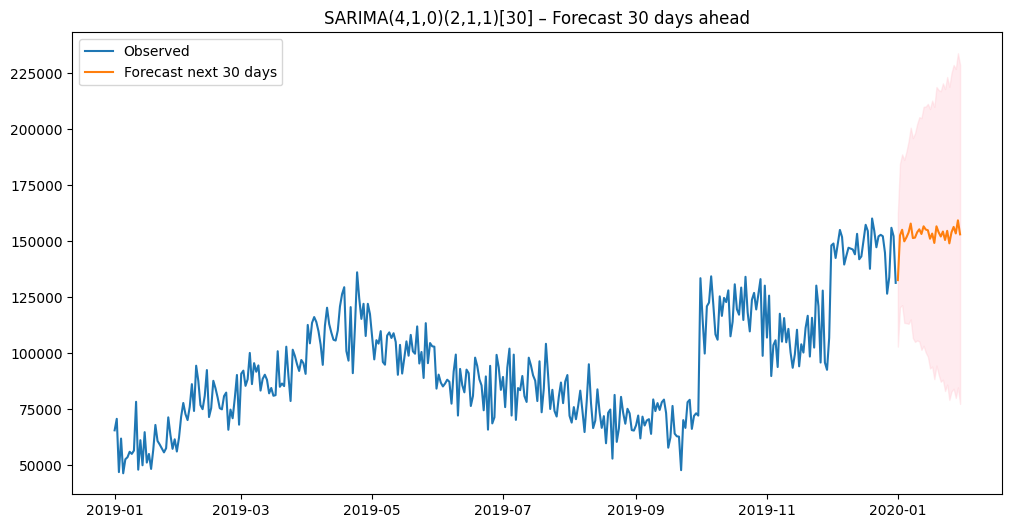

In [26]:
# Forecast for the next 30 days
n_steps = 30  
forecast_future = monthly_sarima.get_forecast(steps=n_steps)
forecast_mean = forecast_future.predicted_mean
forecast_ci = forecast_future.conf_int()

# Assign time index to forecast
forecast_index = pd.date_range(
    start=daily_sales.index[-1] + pd.Timedelta(days=1),
    periods=n_steps, freq="D"
)
forecast_mean.index = forecast_index
forecast_ci.index = forecast_index

# Draw chart
plt.figure(figsize=(12,6))
plt.plot(daily_sales['sales'], label="Observed")
plt.plot(forecast_mean, label=f"Forecast next {n_steps} days")
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color="pink", alpha=0.3)
plt.title(f"SARIMA(4,1,0)(2,1,1)[30] – Forecast {n_steps} days ahead")
plt.legend()
plt.show()

This model shows that the forecast fluctuates around a stable level, but the confidence interval is very wide → high uncertainty.

#### To have a definite conclusion, you should compare more indexes such as AIC, MAPE, RMSE on the testing set.

,Model,Seasonality (m),Data,MAE,RMSE,MAPE
0,"SARIMA(2,0,2)(0,1,1)[7]",7,Clean,18570.96,21872.42,14.24
1,"SARIMA(4,1,0)(2,1,1)[30]",30,Clean,16521.60,19369.16,14.00


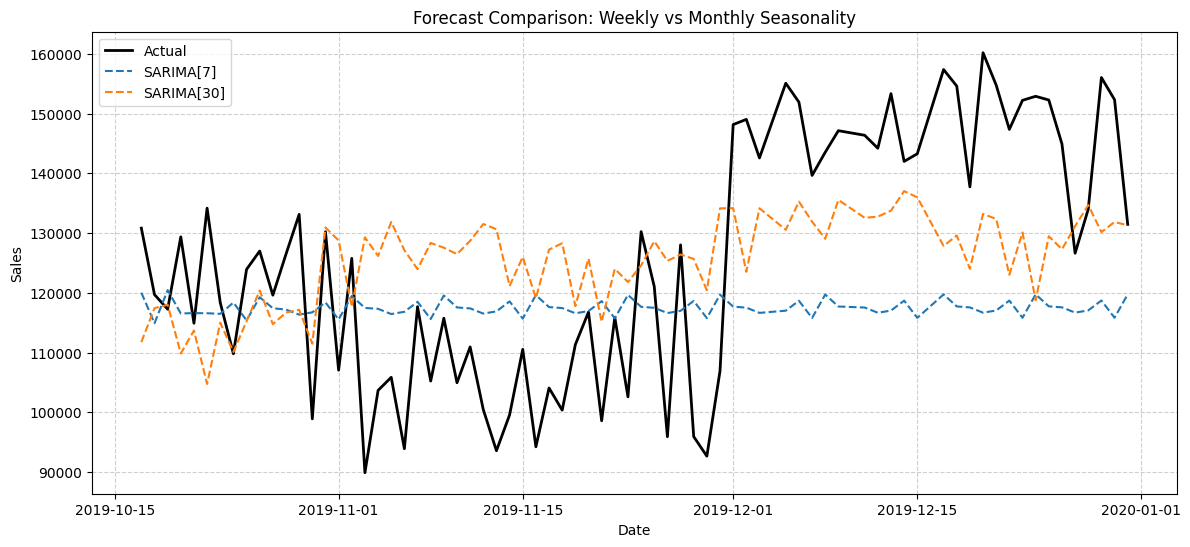

In [27]:
def evaluate_forecast(y_true, y_pred, model_name, data_version, seasonality):
    # Convert to Series if not already
    if not isinstance(y_pred, pd.Series):
        y_pred = pd.Series(y_pred, index=y_true.index[:len(y_pred)])
    
    # Align length
    if len(y_pred) > len(y_true):
        y_pred = y_pred.iloc[-len(y_true):]
    elif len(y_pred) < len(y_true):
        y_pred = y_pred.reindex(y_true.index)
    
    # Calculate metrics
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = (np.abs((y_true - y_pred) / y_true)
            .replace([np.inf, -np.inf], np.nan).dropna()).mean() * 100
    
    # Returns aligned dictionary + y_pred
    return {
        "Model": model_name,
        "Seasonality (m)": seasonality,
        "Data": data_version,
        "MAE": round(mae, 2),
        "RMSE": round(rmse, 2),
        "MAPE": round(mape, 2)
    }, y_pred

# === 2. Combine results from 2 different SARIMA models ===
results = []

res_weekly, y_pred_weekly_aligned = evaluate_forecast(
    y_test, y_pred_weekly,
    "SARIMA(2,0,2)(0,1,1)[7]", "Clean", 7
)
results.append(res_weekly)

res_m30_outlier, forecast_m30_outlier_aligned = evaluate_forecast(
    y_test, forecast_m30,
    "SARIMA(4,1,0)(2,1,1)[30]", "Clean", 30
)
results.append(res_m30_outlier)

# Convert the result list to a DataFrame for easy comparison
df_results = pd.DataFrame(results)
display(df_results)

# === 3. Draw overlay chart to compare actual vs forecast from 3 models ===
plt.figure(figsize=(14,6))

# Plot actual sequence
plt.plot(y_test.index, y_test, label="Actual", color="black", linewidth=2)

# Prediction plot of each model (using aligned version)
plt.plot(y_test.index, y_pred_weekly_aligned, label="SARIMA[7]", linestyle="--")
plt.plot(y_test.index, forecast_m30_outlier_aligned, label="SARIMA[30]", linestyle="--")


# Add title, label and legend
plt.title("Forecast Comparison: Weekly vs Monthly Seasonality")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()

# Add grid for easier reading of chart
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


#### Comparison between the two models shows that SARIMA(4,1,0)(2,1,1)[30] has lower MAE, RMSE and MAPE indices than SARIMA(2,0,2)(0,1,1)[7]. This proves that the model with 30-day period gives more accurate forecast results and better fits the data.

#### Forecasting with best model

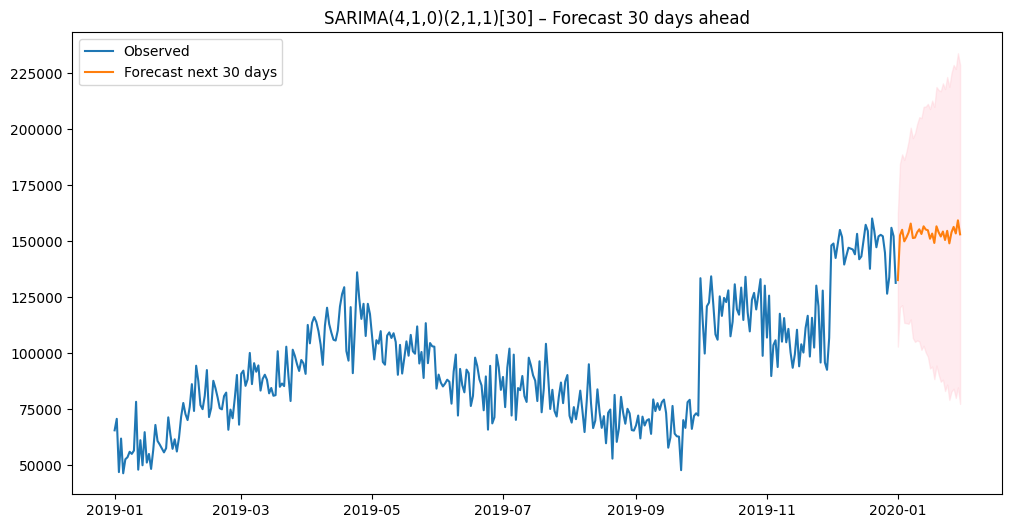

In [28]:
# Forecast for the next 30 days
n_steps = 30  
forecast_future = monthly_sarima.get_forecast(steps=n_steps)
forecast_mean = forecast_future.predicted_mean
forecast_ci = forecast_future.conf_int()

# Assign time index to forecast
forecast_index = pd.date_range(
    start=daily_sales.index[-1] + pd.Timedelta(days=1),
    periods=n_steps, freq="D"
)
forecast_mean.index = forecast_index
forecast_ci.index = forecast_index

# Draw chart
plt.figure(figsize=(12,6))
plt.plot(daily_sales['sales'], label="Observed")
plt.plot(forecast_mean, label=f"Forecast next {n_steps} days")
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color="pink", alpha=0.3)
plt.title(f"SARIMA(4,1,0)(2,1,1)[30] – Forecast {n_steps} days ahead")
plt.legend()
plt.show()

SARIMA(4,1,0)(2,1,1)[30] gives a fairly stable 30-day forecast, closely following the observed trend, with a reasonable confidence interval and few large fluctuations.

The model reflects the trend and seasonality, however, the confidence band is still quite wide.

#### Conclusion

With an average error of 14%, the company can forecast next month's demand relatively accurately.

This helps ABC Retail:

Better planning of goods/inventory.

Reduce costs of excess or shortage of goods.

Optimize marketing campaigns according to monthly sales cycles.